Flare finding procedure, following Davenport 2016's Section 3: https://arxiv.org/pdf/1607.03494.pdf

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search
import theano
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import theano.tensor as tt
from scipy.signal import savgol_filter, correlate
from pymc3.step_methods.hmc import quadpotential
import corner
import pandas as pd

# import Davenport's Appaloosa code snippets
import appaloosa_snippets.appaloosa as appaloosa
import appaloosa_snippets.detrend as detrend
import appaloosa_snippets.aflare as aflare

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from astropy.io import fits
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [3]:
data = fits.getdata(filename,header=True,ext=1)
lc = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(lc)
#lc = lc.loc[(lc.SAP_QUALITY==5) | (lc.SAP_QUALITY==5) | (lc.SAP_QUALITY==5)] # empty, which is good
#print(lc)

             TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR  \
0     2905.377230  0.005332     136855  614164.8125     22.716827   
1     2905.397662  0.005331     136856  614196.0000     22.708811   
2     2905.418095  0.005329     136857  614179.6250     22.713530   
3     2905.438527  0.005328     136858  614099.5000     22.717106   
4     2905.458959  0.005327     136859  614238.1875     22.723835   
...           ...       ...        ...          ...           ...   
3857  2984.182353 -0.001931     140712  629393.1875     23.852659   
3858  2984.202784 -0.001933     140713  632472.3125     23.898970   
3859  2984.223216 -0.001935     140714  630402.6250     23.880606   
3860  2984.243648 -0.001937     140715  629185.0000     23.865633   
3861  2984.264080 -0.001939     140716  628144.9375     23.860067   

           SAP_BKG  SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  \
0     19529.195312     7.201994          NaN              NaN       524288   
1     19530.005

In [ ]:
"""
# then flatten between gaps
maxgap = 0.125
lc['flux'] = detrend.GapFlat(lc.TIME, lc.PDCSAP_FLUX, maxgap=maxgap)
print(lc['flux'])

#find continuous observing periods
_, dlr = detrend.FindGaps(lc.time.values, maxgap=maxgap)
if debug is True:
    print("dl, dr: {}".format(dlr))
print(dlr)

# uQtr = np.unique(qtr)
if debug is True:
    print(str(datetime.datetime.now()) + ' MultiFind started')
istart, istop, lc['flux_model'] = MultiFind(lc,dlr,gapwindow=gapwindow,
                                            debug=debug, mode=mode)

df1 = pd.DataFrame({'istart':istart,
                    'istop':istop,
                    'ed68':np.full_like(istart,-99),
                    'ed90':np.full_like(istart,-99)})
print(df1)
"""

In [4]:
### PREP

# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
lc = lc.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(lc))
    
pre = lc.loc[:1611] # next record is the beginning of the flare, so stop here
post = lc.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = lc.loc[2337:] # start from end of the gap in data until end of time series data

# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

# calculate normalized flux
def normalize_flux(lc):
    return (lc/np.median(lc)) - 1

3255


### Pre Flare

#### 1: GapFlat

findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.


32
1      -0.015936
2      -0.015972
3      -0.016081
4      -0.015839
5      -0.014598
          ...   
1607    0.000469
1608    0.000106
1609    0.000113
1610   -0.000049
1611   -0.000154
Name: PDCSAP_FLUX, Length: 1511, dtype: float32
[         nan          nan          nan ... 625134.40625 625048.53125
 624962.03125]
1      -15703.443370
2      -15717.407607
3      -15776.942889
4      -15617.924209
5      -14836.164060
            ...     
1607      687.562236
1608      462.941316
1609      468.507672
1610      369.386332
1611      305.077302
Name: PDCSAP_FLUX, Length: 1511, dtype: float64
-759.0660443305969


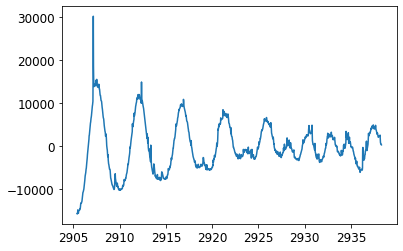

In [5]:
# rolling median subtraction with kernel (window) size of 0.01*time series length
# taken from Appaloosa code: https://github.com/jradavenport/appaloosa/blob/master/appaloosa/appaloosa.py
order = 3
kernel = int(len(lc)/100)
if kernel < 10:
    kernel = 10
print(kernel)

# time series-wide stuff
resid = lc.PDCSAP_FLUX - lc.PDCSAP_FLUX.rolling(kernel).median()
sig_i = np.nanmedian(pd.Series(lc.PDCSAP_FLUX).rolling(kernel, center=True).std())
tot_med = np.nanmedian(lc.PDCSAP_FLUX)

# chunk-specific stuff
med = np.nanmedian(pre.PDCSAP_FLUX)
norm_flux = pre.PDCSAP_FLUX/med - 1
#norm_flux = pre.PDCSAP_FLUX/med
flux_sm = np.array(pre.PDCSAP_FLUX.rolling(kernel).median())
print(norm_flux)
print(flux_sm)
#flux_sm = np.array(norm_flux.rolling(kernel).median())
indx = np.isfinite(flux_sm)
fit = np.polyfit(pre.TIME[indx], flux_sm[indx], order) # 3rd order polynomial
#flux_flat = norm_flux - np.polyval(fit, pre.TIME) # + tot_med
polyval_a = np.polyval(fit, pre.TIME)
flux_flat = pre.PDCSAP_FLUX - np.polyval(fit, pre.TIME)
print(flux_flat)
print(np.median(flux_flat))
plt.plot(pre.TIME, flux_flat)
plt.show()
#print(lc.PDCSAP_FLUX)
#ca = lc.PDCSAP_FLUX - med_i
#cb = np.abs(lc.PDCSAP_FLUX - med_i) / sig_i
#cc = np.abs(lc.PDCSAP_FLUX - med_i - lc.PDCSAP_FLUX_ERR) / sig_i
#print(ca, cb, cc)

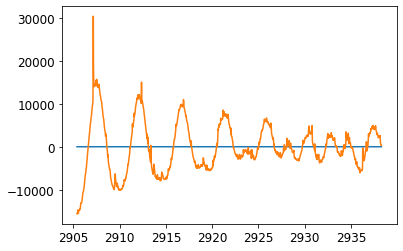

In [10]:
plt.plot(pre.TIME, norm_flux)
plt.plot(pre.TIME, flux_flat)
plt.show()

#### 3. second iteration of smoothing

1      -15562.032547
2      -15576.152949
3      -15635.844264
4      -15476.981485
5      -14695.377105
            ...     
1607      710.530022
1608      485.893849
1609      491.444995
1610      392.308488
1611      327.984333
Name: PDCSAP_FLUX, Length: 1511, dtype: float64
-715.1524693630636


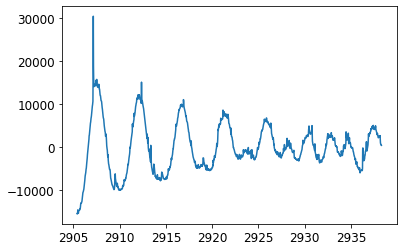

In [6]:
# second iteration of smoothing
flux_sm = np.array(flux_flat.rolling(kernel).median())
indx = np.isfinite(flux_sm)
fit = np.polyfit(pre.TIME[indx], flux_sm[indx], order) # 3rd order polynomial
#plt.plot(pre.TIME, np.polyval(fit, pre.TIME))
flux_flat = flux_flat - np.polyval(fit, pre.TIME) # + tot_med
polyval_b = np.polyval(fit, pre.TIME)
print(flux_flat)
print(np.median(flux_flat))
plt.plot(pre.TIME, flux_flat)
plt.show()

#### 4, 5, 6, 7: ModelLC

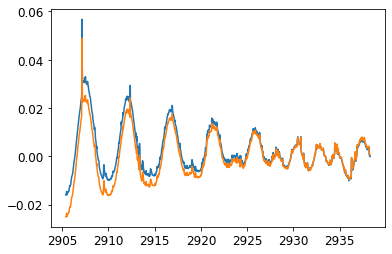

In [11]:
plt.plot(pre.TIME, norm_flux)
plt.plot(pre.TIME, flux_flat/np.nanmedian(pre.PDCSAP_FLUX))

In [20]:
# do iterative rejection and spline fit - like FBEYE did
# also like DFM & Hogg suggest w/ BART
time = pre.TIME
flux = flux_flat
#flux = norm_flux
#flux = flux_flat/np.nanmedian(pre.PDCSAP_FLUX)
error = pre.PDCSAP_FLUX_ERR/med
print(np.mean(flux))
print(error)
box1 = detrend.MultiBoxcar(time, flux, error,
                           kernel=2.0, numpass=2)

# Step 5: iteratively model starspot modulations with Lombscargle until no obvious peak in periodogram
sin1 = detrend.FitSin(time, box1, error, maxnum=5, 
                      maxper=(max(time)-min(time)),
                      per2=False)

# Step 6: Iteratively removes largest flares with 3-pass rolling median
box3 = detrend.MultiBoxcar(time, flux - sin1, error, kernel=0.3) 
t = np.array(time)
dt = np.nanmedian(t[1:] - t[0:-1])
exptime_m = (np.nanmax(time) - np.nanmin(time)) / len(time)
# ksep used to = 0.07...

# Step 7: iterative re-weighted least squares removes smaller flares and decay phases of bigger flares
flux_model_i = detrend.IRLSSpline(time, box3, error, numpass=20, 
                                  ksep=exptime_m*10.)
flux_model_i += sin1
signalfwhm = dt * 2
ftime = np.arange(0, 2, dt)
modelfilter = aflare.aflare1(ftime, 1, signalfwhm, 1)
#Cross-correlate model filter to enhance flare signals
flux_diff = correlate(flux - flux_model_i,
                      modelfilter, mode='same')
print(flux_diff)

-81.3524392391256
1       0.000036
2       0.000036
3       0.000036
4       0.000036
5       0.000036
          ...   
1607    0.000037
1608    0.000037
1609    0.000037
1610    0.000037
1611    0.000037
Name: PDCSAP_FLUX_ERR, Length: 1511, dtype: float32


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


4
[-2511.13975754 -2491.27060946 -2128.90689399 ... -2499.26981839
 -1910.97047199 -1173.96547403]


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


#### Flare detection

1      -14453.061310
2      -14479.678788
3      -14521.937636
4      -14575.254630
5      -14635.036523
            ...     
1607     2023.750343
1608     1899.987829
1609     1737.655148
1610     1531.252848
1611     1275.265484
Name: TIME, Length: 1511, dtype: float64


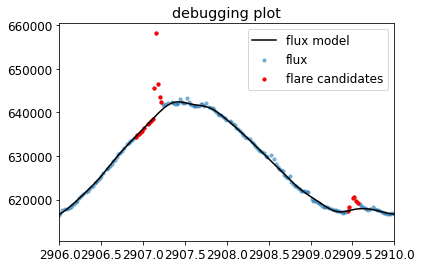

In [32]:
gapwindow = 0.1
minsep = 3

# run final flare-find on DATA - MODEL
isflare = appaloosa.FINDflare(flux_diff, error, N1=3.5, N2=4, N3=3,
                    returnbinary=True, avg_std=True, std_window=25)

# now pick out final flare candidate points from above
cand1 = np.where(isflare > 0)[0]

time = np.array(time)
x1 = np.where((np.abs(time[cand1]-time[-1]) < gapwindow))
x2 = np.where((np.abs(time[cand1]-time[0]) < gapwindow))
cand1 = np.delete(cand1, x1)
cand1 = np.delete(cand1, x2)
if (len(cand1) < 1):
    istart_i = np.array([])
    istop_i = np.array([])
else:
    # find start and stop index, combine neighboring candidates in to same events
    istart_i = cand1[np.append([0], np.where((cand1[1:]-cand1[:-1] > minsep))[0]+1)]
    istop_i = cand1[np.append(np.where((cand1[1:]-cand1[:-1] > minsep))[0], [len(cand1)-1])]
# if start & stop times are the same, add 1 more datum on the end
to1 = np.where((istart_i-istop_i == 0))
if len(to1[0])>0:
    istop_i[to1] += 1

print(flux_model_i)
plt.figure()
plt.title('debugging plot')
#plt.scatter(time, norm_flux, alpha=0.5,label='flux', s=15)
plt.scatter(time, pre.PDCSAP_FLUX, alpha=0.5,label='flux', s=10)
#plt.plot(time,flux_model_i+np.nanmedian(pre.PDCSAP_FLUX), c='black',label='flux model')
plt.plot(time, flux_model_i + polyval_a + polyval_b, c='black', label='flux model')
#plt.scatter(time[cand1], np.array(norm_flux)[cand1], c='red',label='flare candidates', s=15)
plt.scatter(time[cand1], np.array(pre.PDCSAP_FLUX)[cand1], c='red',label='flare candidates', s=10)
plt.xlim(2906, 2910)
plt.legend()
plt.show()

#istart = np.array(np.append(istart, istart_i + le), dtype='int')
#istop = np.array(np.append(istop, istop_i + le), dtype='int')
#flux_model = flux_model_i

8 [array([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]), array([182, 183, 184, 185, 186, 187]), array([316, 317, 318]), array([363, 364, 365]), array([376, 377, 378, 379, 380, 381]), array([1167, 1168, 1169, 1170]), array([1334, 1335, 1336]), array([1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421])]


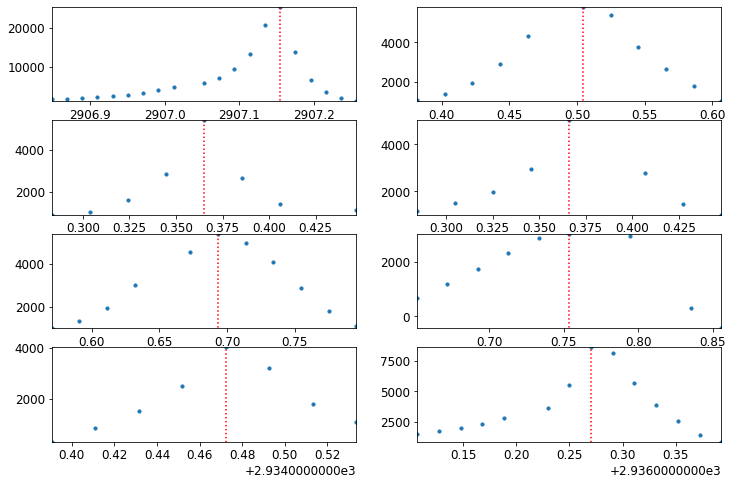

In [33]:
# from https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

flares = consecutive(cand1)
npeaks = len(flares)
buffer_size = 3
print(npeaks, flares)

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    buffer = np.insert(flares[i], 0, np.arange(flares[i][0]-buffer_size, flares[i][0])) # add two points to the left for plot
    buffer = np.append(buffer, np.arange(flares[i][-1], flares[i][-1]+buffer_size)) # add two points to the right for plot
    ax.scatter(time, flux_diff, s=10)
    ax.axvline(time[flares[i]][np.argmax(flux_diff[flares[i]])], -1, 1, color='r', linestyle=':')
    ax.set_xlim(time[buffer][0], time[buffer][-1])
    ax.set_ylim(np.min(flux_diff[buffer])-0.005, np.max(flux_diff[buffer])+0.005)

In [34]:
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))
time - calculate_ref_time(pre)

array([-16.4476865 , -16.42725422, -16.40682193, ...,  16.40682317,
        16.42725479,  16.4476865 ])

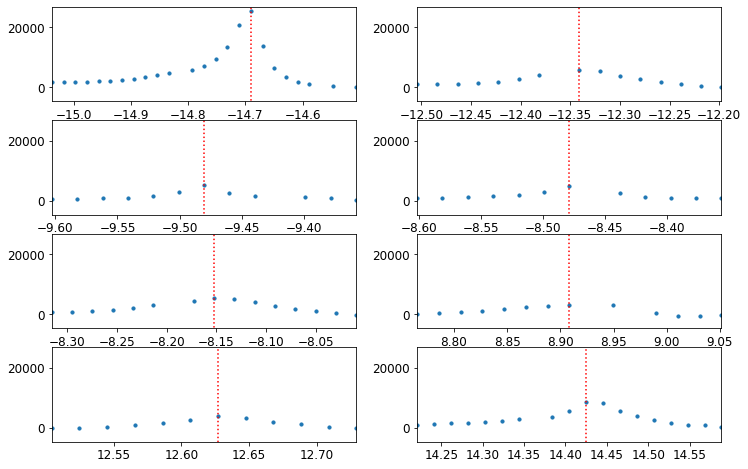

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
new_time = time - calculate_ref_time(pre)
buffer_size = 5
for i in range(npeaks):
    ax = axes[i]
    buffer = np.insert(flares[i], 0, np.arange(flares[i][0]-buffer_size, flares[i][0])) # add two points to the left for plot
    buffer = np.append(buffer, np.arange(flares[i][-1], flares[i][-1]+buffer_size)) # add two points to the right for plot
    ax.scatter(new_time, flux_diff, s=10)
    #ax.scatter(new_time, flux_diff - polyval_a - polyval_b, s=10)
    ax.axvline(new_time[flares[i]][np.argmax(flux_diff[flares[i]])], -1, 1, color='r', linestyle=':')
    ax.set_xlim(new_time[buffer][0], new_time[buffer][-1])
    #ax.set_ylim(np.min(flux_diff[buffer])-1000, np.max(flux_diff[buffer])+1000)

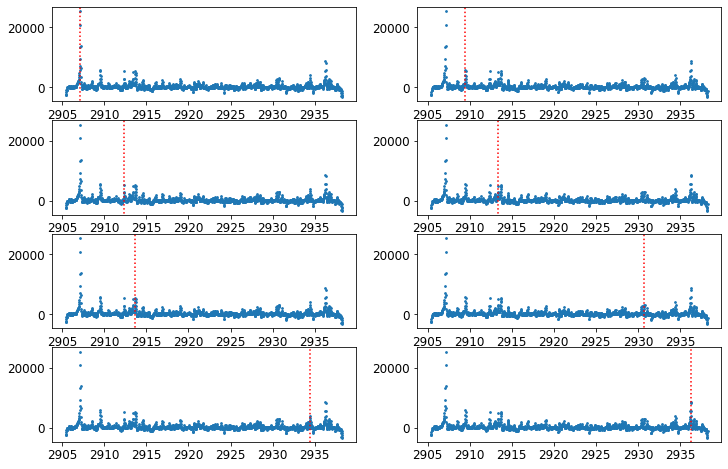

In [36]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    buffer = np.insert(flares[i], 0, np.arange(flares[i][0]-buffer_size, flares[i][0])) # add two points to the left for plot
    buffer = np.append(buffer, np.arange(flares[i][-1], flares[i][-1]+buffer_size)) # add two points to the right for plot
    ax.scatter(time, flux_diff, s=3)
    ax.axvline(time[flares[i]][np.argmax(flux_diff[flares[i]])], -1, 1, color='r', linestyle=':')


### Post Flare, Pre Gap


32


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressio

4
1618    0.008095
1619    0.008116
1620    0.008114
1621    0.008095
1622    0.008061
          ...   
2332   -0.010124
2333   -0.010119
2334   -0.010104
2335   -0.010079
2336   -0.010042
Name: TIME, Length: 671, dtype: float64


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


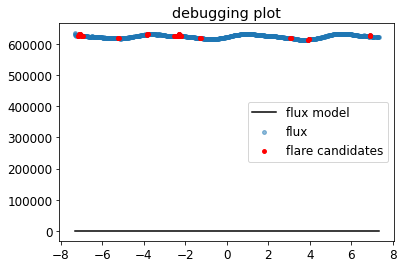

In [57]:
# rolling median subtraction with kernel (window) size of 0.01*time series length
# taken from Appaloosa code: https://github.com/jradavenport/appaloosa/blob/master/appaloosa/appaloosa.py
order = 3
kernel = int(len(lc)/100)
if kernel < 10:
    kernel = 10
print(kernel)

# chunk-specific stuff
med = np.nanmedian(post.PDCSAP_FLUX)
norm_flux = post.PDCSAP_FLUX/med - 1
#flux_sm = np.array(post.PDCSAP_FLUX.rolling(kernel).median())
flux_sm = np.array(norm_flux.rolling(kernel).median())
indx = np.isfinite(flux_sm)
fit = np.polyfit(post.TIME[indx], flux_sm[indx], order) # 3rd order polynomial
polyval_a = np.polyval(fit, post.TIME)
flux_flat = norm_flux - np.polyval(fit, post.TIME)
#flux_flat = post.PDCSAP_FLUX - np.polyval(fit, post.TIME)

# second iteration of smoothing
flux_sm = np.array(flux_flat.rolling(kernel).median())
indx = np.isfinite(flux_sm)
fit = np.polyfit(post.TIME[indx], flux_sm[indx], order) # 3rd order polynomial
polyval_b = np.polyval(fit, post.TIME)
flux_flat = flux_flat - np.polyval(fit, post.TIME)

# do iterative rejection and spline fit - like FBEYE did
# also like DFM & Hogg suggest w/ BART
time = post.TIME - calculate_ref_time(post)
flux = flux_flat
#flux = flux_flat/np.nanmedian(pre.PDCSAP_FLUX)
error = post.PDCSAP_FLUX_ERR/med
box1 = detrend.MultiBoxcar(time, flux, error,
                           kernel=2.0, numpass=5) # formerly numpass=2

# Step 5: iteratively model starspot modulations with Lombscargle until no obvious peak in periodogram
sin1 = detrend.FitSin(time, box1, error, maxnum=5, 
                      maxper=(max(time)-min(time)),
                      per2=False)

# Step 6: Iteratively removes largest flares with 3-pass rolling median
box3 = detrend.MultiBoxcar(time, flux - sin1, error, kernel=0.3) 
t = np.array(time)
dt = np.nanmedian(t[1:] - t[0:-1])
exptime_m = (np.nanmax(time) - np.nanmin(time)) / len(time)
# ksep used to = 0.07...

# Step 7: iterative re-weighted least squares removes smaller flares and decay phases of bigger flares
flux_model_i = detrend.IRLSSpline(time, box3, error, numpass=20, 
                                  ksep=exptime_m*10.)
flux_model_i += sin1
signalfwhm = dt * 2
ftime = np.arange(0, 2, dt)
modelfilter = aflare.aflare1(ftime, 1, signalfwhm, 1)
#Cross-correlate model filter to enhance flare signals
flux_diff = correlate(flux - flux_model_i,
                      modelfilter, mode='same')

# run final flare-find on DATA - MODEL
isflare = appaloosa.FINDflare(flux_diff, error, N1=3.5, N2=4, N3=3,
                    returnbinary=True, avg_std=True, std_window=7) # std_window=25

# now pick out final flare candidate points from above
cand1 = np.where(isflare > 0)[0]

time = np.array(time)
x1 = np.where((np.abs(time[cand1]-time[-1]) < gapwindow))
x2 = np.where((np.abs(time[cand1]-time[0]) < gapwindow))
cand1 = np.delete(cand1, x1)
cand1 = np.delete(cand1, x2)
if (len(cand1) < 1):
    istart_i = np.array([])
    istop_i = np.array([])
else:
    # find start and stop index, combine neighboring candidates in to same events
    istart_i = cand1[np.append([0], np.where((cand1[1:]-cand1[:-1] > minsep))[0]+1)]
    istop_i = cand1[np.append(np.where((cand1[1:]-cand1[:-1] > minsep))[0], [len(cand1)-1])]
# if start & stop times are the same, add 1 more datum on the end
to1 = np.where((istart_i-istop_i == 0))
if len(to1[0])>0:
    istop_i[to1] += 1

print(flux_model_i)
plt.figure()
plt.title('debugging plot')
#plt.scatter(time, norm_flux, alpha=0.5,label='flux', s=15)
plt.scatter(time, post.PDCSAP_FLUX, alpha=0.5,label='flux', s=15)
#plt.plot(time,flux_model_i, c='black',label='flux model')
plt.plot(time,flux_model_i + polyval_a + polyval_b, c='black',label='flux model')
plt.scatter(time[cand1], np.array(post.PDCSAP_FLUX)[cand1], c='red',label='flare candidates', s=15) # norm_flux
plt.legend()
plt.show()

8 [array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([94, 95, 96]), array([156, 157, 158, 159]), array([215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231]), array([272, 273, 274, 275]), array([473, 474, 475]), array([513, 514, 515, 516, 517]), array([652, 653, 654])]


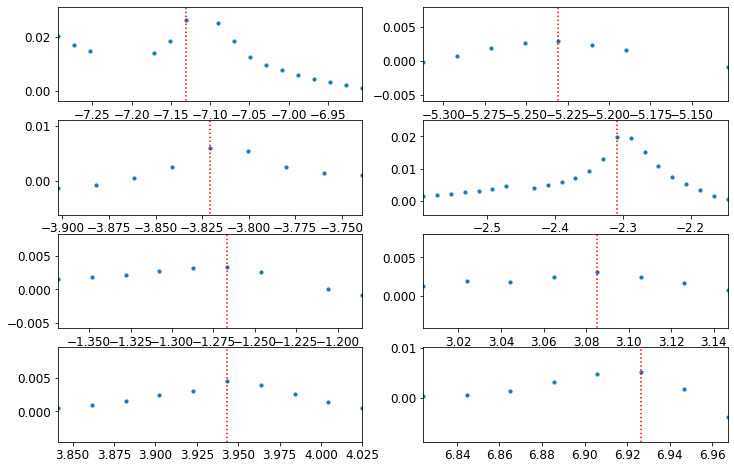

In [58]:
flares = consecutive(cand1)
npeaks = len(flares)
buffer_size = 3
print(npeaks, flares)
new_time = time - calculate_ref_time(post)

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    buffer = np.insert(flares[i], 0, np.arange(flares[i][0]-buffer_size, flares[i][0])) # add points to the left for plot
    buffer = np.append(buffer, np.arange(flares[i][-1], flares[i][-1]+buffer_size)) # add points to the right for plot
    ax.scatter(time, flux_diff, s=10)
    ax.axvline(time[flares[i]][np.argmax(flux_diff[flares[i]])], -1, 1, color='r', linestyle=':')
    ax.set_xlim(time[buffer][0], time[buffer][-1])
    ax.set_ylim(np.min(flux_diff[buffer])-0.005, np.max(flux_diff[buffer])+0.005)

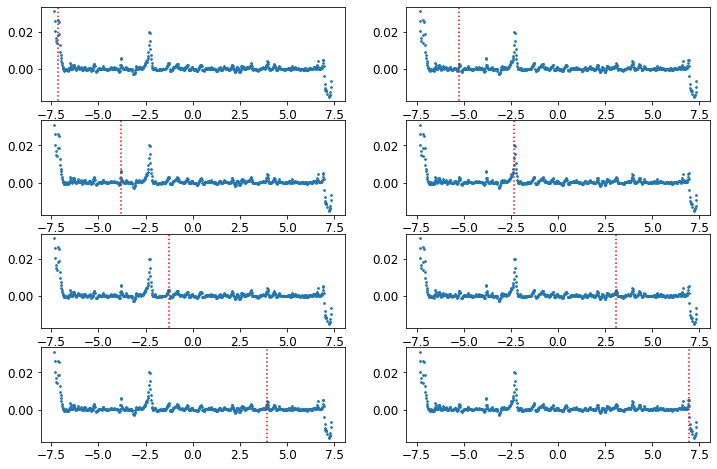

In [59]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    buffer = np.insert(flares[i], 0, np.arange(flares[i][0]-buffer_size, flares[i][0])) # add points to the left for plot
    buffer = np.append(buffer, np.arange(flares[i][-1], flares[i][-1]+buffer_size)) # add points to the right for plot
    ax.scatter(time, flux_diff, s=3)
    ax.axvline(time[flares[i]][np.argmax(flux_diff[flares[i]])], -1, 1, color='r', linestyle=':')


### Post flare, post gap

32


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressio

4
dt:  0.020431616339919856
2594   -0.019738
2595   -0.019982
2596   -0.020223
2597   -0.020458
2598   -0.020687
          ...   
3856    0.017947
3857    0.017262
3859    0.015988
3860    0.015417
3861    0.014903
Name: TIME, Length: 1071, dtype: float64


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


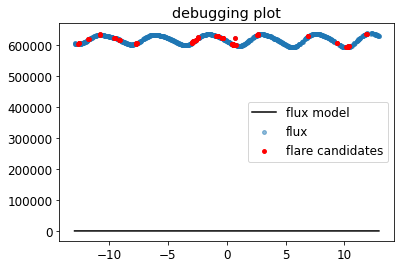

In [69]:
# rolling median subtraction with kernel (window) size of 0.01*time series length
# taken from Appaloosa code: https://github.com/jradavenport/appaloosa/blob/master/appaloosa/appaloosa.py
order = 3
kernel = int(len(lc)/100)
if kernel < 10:
    kernel = 10
print(kernel)

# chunk-specific stuff
med = np.nanmedian(postgap.PDCSAP_FLUX)
norm_flux = postgap.PDCSAP_FLUX/med - 1
#flux_sm = np.array(postgap.PDCSAP_FLUX.rolling(kernel).median())
flux_sm = np.array(norm_flux.rolling(kernel).median())
indx = np.isfinite(flux_sm)
fit = np.polyfit(postgap.TIME[indx], flux_sm[indx], order) # 3rd order polynomial
polyval_a = np.polyval(fit, postgap.TIME)
flux_flat = norm_flux - np.polyval(fit, postgap.TIME)
#flux_flat = postgap.PDCSAP_FLUX - np.polyval(fit, postgap.TIME)

# second iteration of smoothing
flux_sm = np.array(flux_flat.rolling(kernel).median())
indx = np.isfinite(flux_sm)
fit = np.polyfit(postgap.TIME[indx], flux_sm[indx], order) # 3rd order polynomial
polyval_b = np.polyval(fit, postgap.TIME)
flux_flat = flux_flat - np.polyval(fit, postgap.TIME)

# do iterative rejection and spline fit - like FBEYE did
# also like DFM & Hogg suggest w/ BART
time = postgap.TIME - calculate_ref_time(postgap)
flux = flux_flat
#flux = flux_flat/np.nanmedian(pre.PDCSAP_FLUX)
error = postgap.PDCSAP_FLUX_ERR/med
box1 = detrend.MultiBoxcar(time, flux, error,
                           kernel=2.0, numpass=5) # formerly numpass=2

# Step 5: iteratively model starspot modulations with Lombscargle until no obvious peak in periodogram
sin1 = detrend.FitSin(time, box1, error, maxnum=5, 
                      maxper=(max(time)-min(time)),
                      per2=False)

# Step 6: Iteratively removes largest flares with 3-pass rolling median
box3 = detrend.MultiBoxcar(time, flux - sin1, error, kernel=0.3) 
t = np.array(time)
dt = np.nanmedian(t[1:] - t[0:-1])
print("dt: ", dt)
exptime_m = (np.nanmax(time) - np.nanmin(time)) / len(time)
# ksep used to = 0.07...

# Step 7: iterative re-weighted least squares removes smaller flares and decay phases of bigger flares
flux_model_i = detrend.IRLSSpline(time, box3, error, numpass=20, 
                                  ksep=exptime_m*10.)
flux_model_i += sin1
signalfwhm = dt * 2 # 2 times cadence
ftime = np.arange(0, 2, dt)
modelfilter = aflare.aflare1(ftime, 1, signalfwhm, 1, upsample=False)
#print("modelfilter: ", modelfilter)

#Cross-correlate model filter to enhance flare signals
flux_diff = correlate(flux - flux_model_i,
                      modelfilter, mode='same')

# run final flare-find on DATA - MODEL
isflare = appaloosa.FINDflare(flux_diff, error, N1=3.5, N2=4, N3=2, # N3=2 for long cadence data
                    returnbinary=True, avg_std=True, std_window=7) # std_window=25

# now pick out final flare candidate points from above
cand1 = np.where(isflare > 0)[0]

time = np.array(time)
x1 = np.where((np.abs(time[cand1]-time[-1]) < gapwindow))
x2 = np.where((np.abs(time[cand1]-time[0]) < gapwindow))
cand1 = np.delete(cand1, x1)
cand1 = np.delete(cand1, x2)
if (len(cand1) < 1):
    istart_i = np.array([])
    istop_i = np.array([])
else:
    # find start and stop index, combine neighboring candidates in to same events
    istart_i = cand1[np.append([0], np.where((cand1[1:]-cand1[:-1] > minsep))[0]+1)]
    istop_i = cand1[np.append(np.where((cand1[1:]-cand1[:-1] > minsep))[0], [len(cand1)-1])]
# if start & stop times are the same, add 1 more datum on the end
to1 = np.where((istart_i-istop_i == 0))
if len(to1[0])>0:
    istop_i[to1] += 1

print(flux_model_i)
plt.figure()
plt.title('debugging plot')
#plt.scatter(time, norm_flux, alpha=0.5,label='flux', s=15)
plt.scatter(time, postgap.PDCSAP_FLUX, alpha=0.5,label='flux', s=15)
#plt.scatter(time, flux_diff, s=15)
#plt.plot(time,flux_model_i, c='black',label='flux model')
plt.plot(time,flux_model_i + polyval_a + polyval_b, c='black',label='flux model')
plt.scatter(time[cand1], np.array(postgap.PDCSAP_FLUX)[cand1], c='red',label='flare candidates', s=15) # norm_flux
plt.legend()
plt.show()

16 [array([15, 16, 17, 18]), array([53, 54]), array([92, 93]), array([145, 146, 147]), array([164, 165]), array([227, 228, 229, 230]), array([433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
       446]), array([449, 450, 451, 452, 453, 454]), array([523, 524, 525, 526, 527, 528, 529, 530]), array([543, 544, 545, 546, 547, 548, 549]), array([582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
       595, 596]), array([675, 676, 677]), array([849, 850]), array([953, 954]), array([983, 984, 985, 986, 987, 988, 989, 990, 991, 992]), array([1042, 1043])]


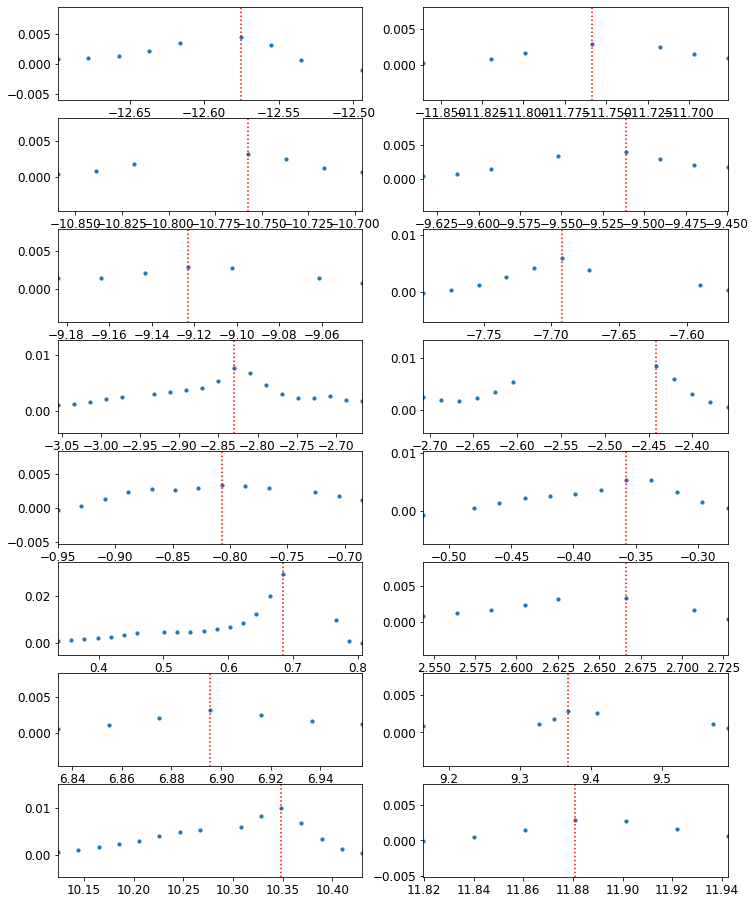

In [65]:
flares = consecutive(cand1)
npeaks = len(flares)
buffer_size = 3
print(npeaks, flares)
new_time = time - calculate_ref_time(postgap)

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    buffer = np.insert(flares[i], 0, np.arange(flares[i][0]-buffer_size, flares[i][0])) # add points to the left for plot
    buffer = np.append(buffer, np.arange(flares[i][-1], flares[i][-1]+buffer_size)) # add points to the right for plot
    ax.scatter(time, flux_diff, s=10)
    ax.axvline(time[flares[i]][np.argmax(flux_diff[flares[i]])], -1, 1, color='r', linestyle=':')
    ax.set_xlim(time[buffer][0], time[buffer][-1])
    ax.set_ylim(np.min(flux_diff[buffer])-0.005, np.max(flux_diff[buffer])+0.005)

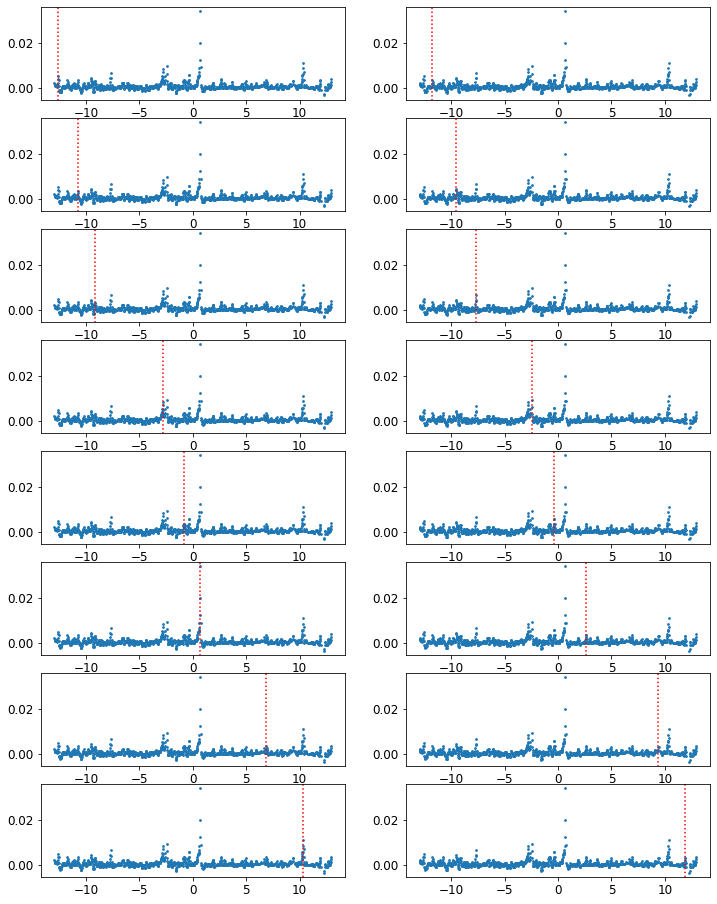

In [56]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    buffer = np.insert(flares[i], 0, np.arange(flares[i][0]-buffer_size, flares[i][0])) # add points to the left for plot
    buffer = np.append(buffer, np.arange(flares[i][-1], flares[i][-1]+buffer_size)) # add points to the right for plot
    ax.scatter(time, flux_diff, s=3)
    ax.axvline(time[flares[i]][np.argmax(flux_diff[flares[i]])], -1, 1, color='r', linestyle=':')
